##### Loading Neccessary libraries

##### The most suitable version for the implementation for the EDSR mode is tensorflow (2.15.0)

In [14]:
!pip3 install --upgrade tensorflow==2.15.0

     |████████████████████████████████| 475.2 MB 87 kB/s s eta 0:00:01    |███▏                            | 46.8 MB 10.6 MB/s eta 0:00:41
     |████████████████████████████████| 1.7 MB 10.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 9.4 MB/s eta 0:00:01
     |████████████████████████████████| 5.5 MB 10.0 MB/s eta 0:00:01
     |████████████████████████████████| 441 kB 11.2 MB/s eta 0:00:01
     |████████████████████████████████| 189 kB 12.0 MB/s eta 0:00:01
     |████████████████████████████████| 181 kB 12.4 MB/s eta 0:00:01
     |████████████████████████████████| 85 kB 6.2 MB/s  eta 0:00:01
     |████████████████████████████████| 151 kB 12.8 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Attempting uninstall: tensorboard
    Found existing installation: tensorboar

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

AUTOTUNE = tf.data.AUTOTUNE

No Bottleneck unit testing available.


In [2]:
import cv2
from PIL import Image
import random
import os
import re
from tensorflow.keras.preprocessing.image import img_to_array
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

##### code for sorting files

In [3]:
#function to sort data in ascending order
def sorted_alphanumeric(data): 
    #rename the names of images to lower case
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    #arrange in ascending order if the are number
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

##### Turning images into array of list

In [4]:
#Faster Method
#creating of file paths
train_high_img = []
train_low_img = []

def d_creation(path,data_l):
    files = os.listdir(path)
    files = sorted_alphanumeric(files)
    for name in tqdm(files):
        img = Image.open(path+name)
        img = np.asarray(img)
        if (img.shape[0]!=512) or (img.shape[0]>256):
            img = cv2.resize(img, (256, 256))
        if 'LR' in path:
            img = cv2.resize(img, (128, 128))
        img = img.astype('float32') / 255.0
        if img.shape[2]!=3:
            img = img[:,:,:3]
        data_l.append(img_to_array(img))
    return data_l

train_high_img = d_creation('Processed_Data/HR/',train_high_img )
train_low_img = d_creation('Processed_Data/LR/',train_low_img )

100%|██████████| 2202/2202 [00:03<00:00, 666.81it/s]


In [5]:
print(len(train_high_img))
print(len(train_low_img))

2202
2202


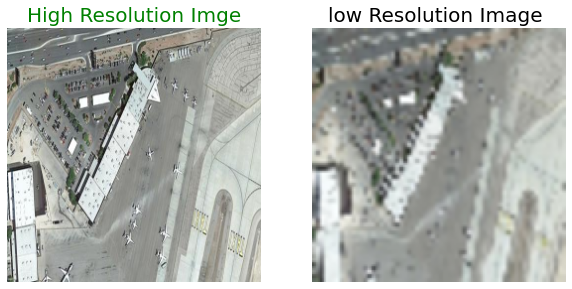

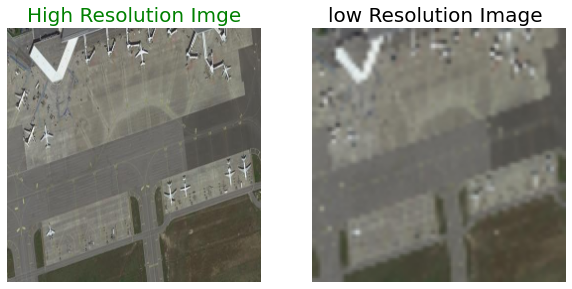

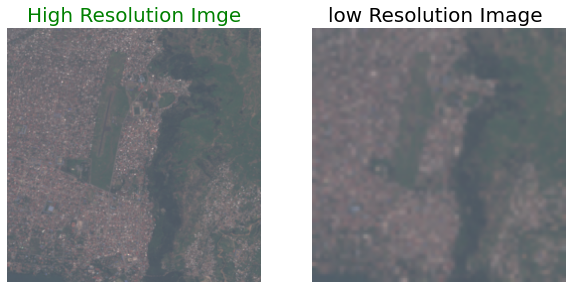

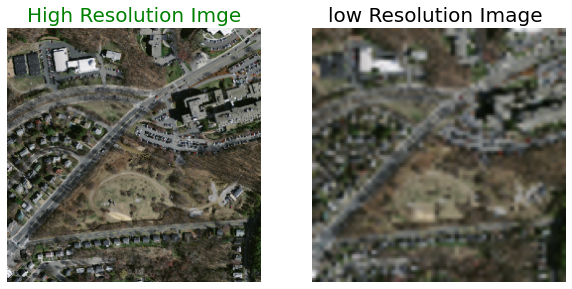

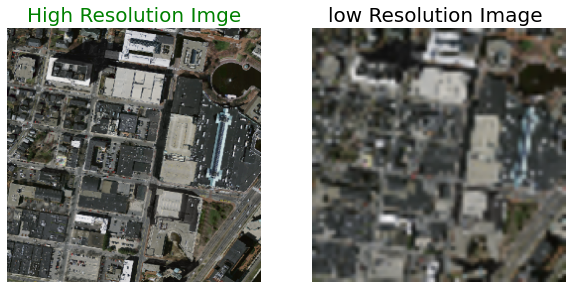

In [6]:
for i in range(5):
    a = np.random.randint(0,100)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.title('High Resolution Imge', color = 'green', fontsize = 20)
    plt.imshow(train_high_img[a])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('low Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(train_low_img[a])
    plt.axis('off')

The above images the HR images with their respective LR counterpar stored in two seprates list

Now Are data is almost ready for training models. We rehape the dimension of the array to (N,W,H,C) where N represent the number of data points, W and H presenting width and height respectively. 

In [7]:
SIZE = 256
train_high_image = np.reshape(train_high_img,(len(train_high_img),SIZE,SIZE,3))
# val_high_image= np.reshape(val_high_img,(len(val_high_img),SIZE,SIZE,3))
print("Shape of training images:",train_high_image.shape)
#print("Shape of test images:",test_high_image.shape)
#print("Shape of validation images:",val_high_image.shape)

Shape of training images: (2202, 256, 256, 3)


In [10]:
SIZE = 128
train_low_image = np.reshape(train_low_img,(len(train_low_img),SIZE,SIZE,3))
#val_low_image = np.reshape(val_low_img,(len(val_low_img),SIZE,SIZE,3))


The code below is used to split the preprocessed data into train and validation set.

In [11]:
train_h,val_h ,train_l, val_l =  train_test_split(train_high_image,train_low_image,test_size=0.3,train_size=0.7)

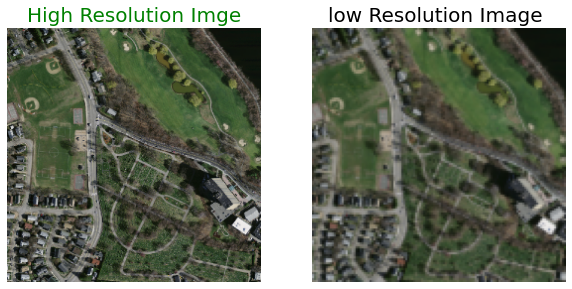

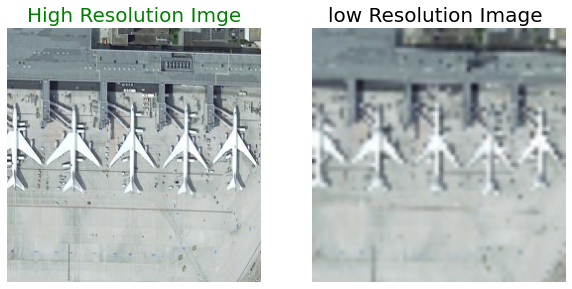

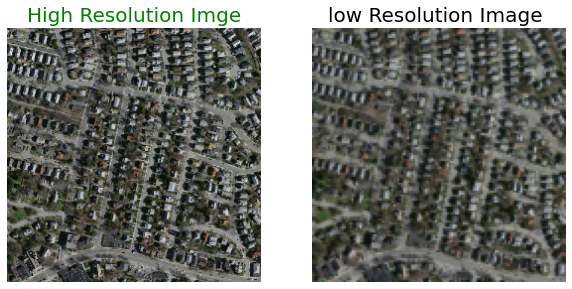

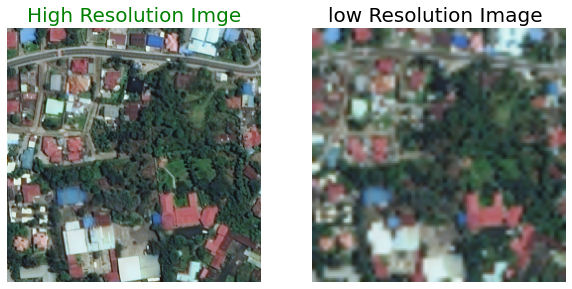

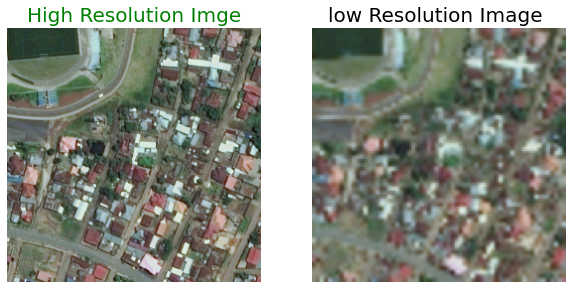

In [13]:
for i in range(5):
    a = np.random.randint(0,100)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.title('High Resolution Imge', color = 'green', fontsize = 20)
    plt.imshow(train_h[a])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('low Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(train_l[a])
    plt.axis('off')

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense ,Conv2D,MaxPooling2D ,Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from keras import layers
from tensorflow.keras.utils import plot_model


#### Defining the EDSR model the Weights will be updated

In [15]:
class EDSRModel(tf.keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x,y =data
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

The below code is the implementation of the Residual blosck, upsampling layer and the combine model of the EDSR

In [16]:
# Residual Block
def ResBlock(inputs):
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.Add()([inputs, x])
    return x


def Upsampling(inputs, factor=2, **kwargs):
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(inputs)
    x = tf.nn.depth_to_space(x, block_size=factor)
    
    #To upscaale your predicted image by 4, you can uncomment the code below
    #x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(x)
    #x = tf.nn.depth_to_space(x, block_size=factor)
    return x


def make_model(num_filters, num_of_residual_blocks):
    # Flexible Inputs to input_layer
    input_layer = layers.Input(shape=(None, None, 3))
    # Scaling Pixel Values
    #x = layers.Rescaling(scale=1.0 / 255)(input_layer)
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(input_layer)

    # 16 residual blocks
    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(x_new)

    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    x = Upsampling(x)
    x = layers.Conv2D(3, 3, padding="same")(x)

    #output_layer = layers.Rescaling(scale=255)(x)
    output_layer = x
    return EDSRModel(input_layer, output_layer)


model = make_model(num_filters=64, num_of_residual_blocks=16)


Our EDSR model is now modified and ready to be compiled with ADAM regularizer and other hyperparamter

In [18]:
optim_edsr = keras.optimizers.Adam(
    learning_rate=keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[5000], values=[1e-4, 5e-5]
    )
)
# Compiling model with loss as mean absolute error(L1 Loss) and metric as psnr as proposed by
# the author
model.compile(optimizer=optim_edsr, loss='mae', metrics=[PSNR])

In [30]:
history=model.fit(train_l,train_h,batch_size=1, epochs=30,
          validation_data = (val_l,val_h))

Epoch 1/30
1541/1541 [==============================] - 1094s 710ms/step - loss: 0.0434 - PSNR: 25.5279 - val_loss: 0.0424 - val_PSNR: 25.5986
Epoch 2/30
1541/1541 [==============================] - 1090s 707ms/step - loss: 0.0422 - PSNR: 25.8128 - val_loss: 0.0416 - val_PSNR: 25.7035
Epoch 3/30
1541/1541 [==============================] - 1096s 711ms/step - loss: 0.0405 - PSNR: 26.1537 - val_loss: 0.0393 - val_PSNR: 26.3105
Epoch 4/30
1541/1541 [==============================] - 1101s 715ms/step - loss: 0.0401 - PSNR: 26.2814 - val_loss: 0.0391 - val_PSNR: 26.3508
Epoch 5/30
1541/1541 [==============================] - 1094s 710ms/step - loss: 0.0399 - PSNR: 26.3169 - val_loss: 0.0392 - val_PSNR: 26.3085
Epoch 6/30
1541/1541 [==============================] - 1094s 710ms/step - loss: 0.0395 - PSNR: 26.4157 - val_loss: 0.0389 - val_PSNR: 26.3967
Epoch 7/30
1541/1541 [==============================] - 1092s 709ms/step - loss: 0.0393 - PSNR: 26.4363 - val_loss: 0.0385 - val_PSNR: 26.4858

In [144]:
history.model.save('EDSR_model')

INFO:tensorflow:Assets written to: EDSR_model/assets


INFO:tensorflow:Assets written to: EDSR_model/assets


###### Loss Graph For EDSR

<ipython-input-40-bffdddf1f815>:15: MatplotlibDeprecationWarning: 
The 'quality' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'quality': ...} instead. If any parameter follows 'quality', they should be passed as keyword, not positionally.
  plt.savefig('plot.jpg',quality=95)


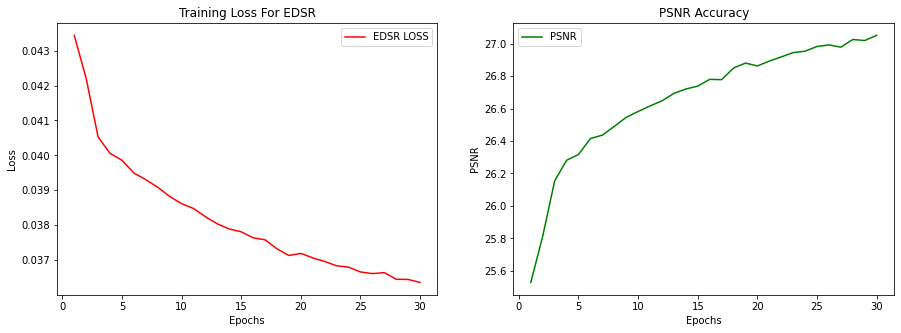

In [40]:
epochs = range(1, len(h1['loss']) + 1)  # Assuming model1_loss and model2_loss have the same length
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epochs, h1['loss'], 'r', label='EDSR LOSS')
plt.title('Training Loss For EDSR')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, h1['PSNR'], 'g', label='PSNR')
plt.title('PSNR Accuracy')
plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.legend()
plt.savefig('plot.jpg',quality=95)
plt.show()

#### Below is the structure of the EDSR Network

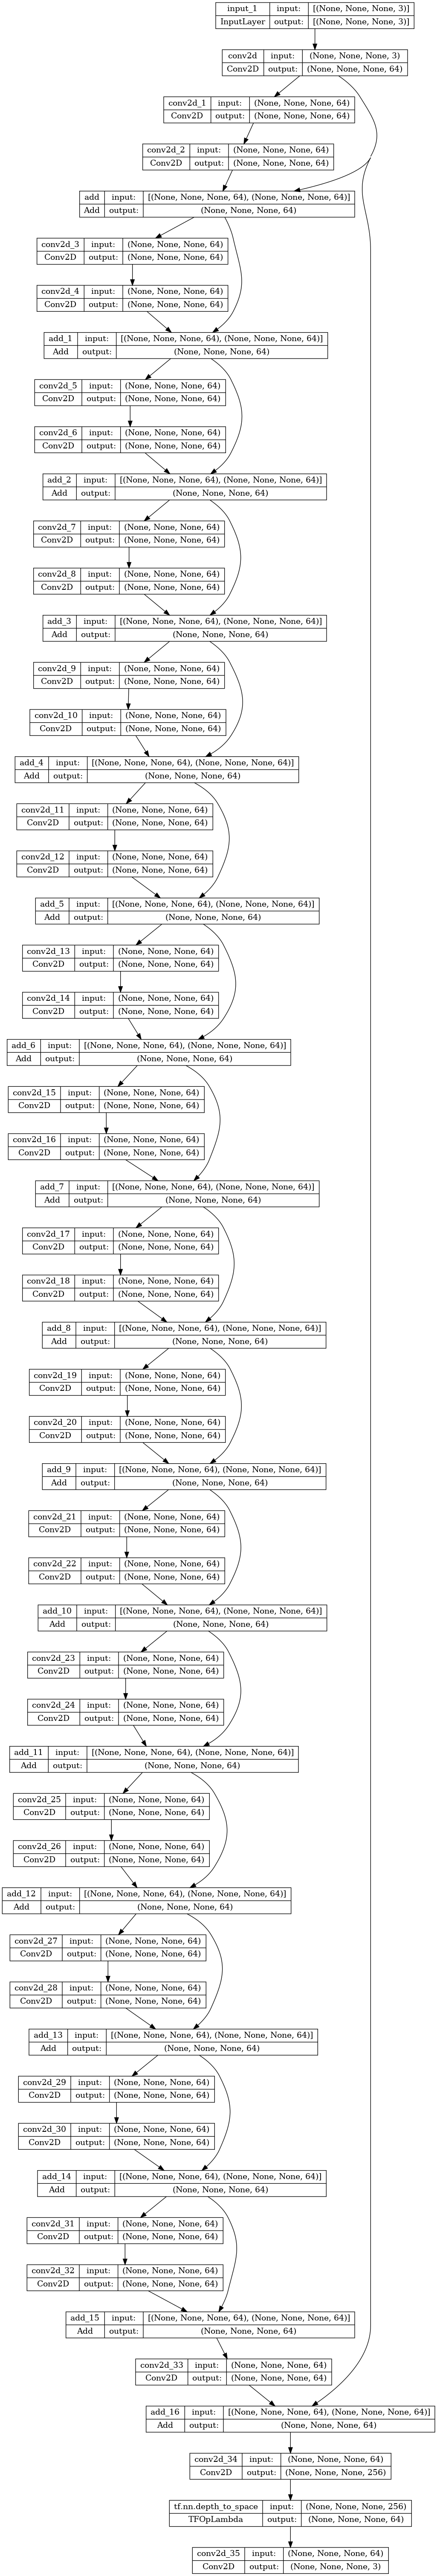

In [42]:
plot_model(model, to_file ='super_res.png',show_shapes=True)

In [17]:
def PSNR(y_true,y_pred):
    mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
    return 20 * log10(1/ (mse ** 0.5))

def log10(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator

def pixel_MSE(y_true,y_pred):
    return tf.reduce_mean( (y_true - y_pred) ** 2 )

In [85]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(15,10))
    plt.subplot(1,3,1)
    plt.title('Original ', color = 'black', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('LR  ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    a = float(PSNR(train_high_image[i],predicted))
    a = round(a,2)
    b = float(tf.image.ssim(train_high_image[i],predicted,max_val=1))
    b = round(b,2)
    plt.title('Predicted HR ({}/{})'.format(a,b), color = 'Black', fontsize = 20)
    plt.imshow(predicted)
    plt.savefig('output.jpg',quality=95)
    plt.show()

Testing on a test set

In [15]:
test_high_img = []
test_low_img = []
test_high_img = data_creation('Data/Test/HR',test_high_img )
test_low_img = data_creation('Data/Test/LR',test_low_img )

100%|██████████| 16/16 [00:00<00:00, 724.51it/s]


1/1 [==============================] - 0s 74ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
<ipython-input-85-7d197eb7f649>:16: MatplotlibDeprecationWarning: 
The 'quality' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'quality': ...} instead. If any parameter follows 'quality', they should be passed as keyword, not positionally.
  plt.savefig('output.jpg',quality=95)


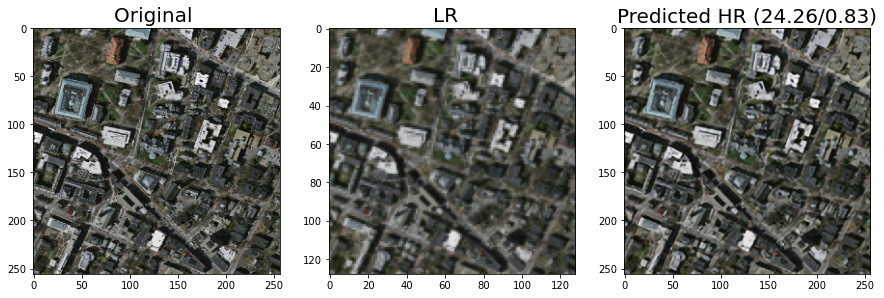

PSNR 24.25638198852539 dB SSIM 0.8325651288032532


In [86]:
for i in range(902,903):
    predicted = history.model.predict(train_low_image[i].reshape(1,128,128,3)).reshape(256,256,3)
    plot_images(train_high_image[i],train_low_image[i],predicted)
    print('PSNR',float(PSNR(train_high_image[i],predicted)),'dB', "SSIM",float(tf.image.ssim(train_high_image[i],predicted,max_val=1)))

In [101]:
r_img = Image.open('nice.jpg')

In [104]:
r_img = r_img.resize((128,128))

In [105]:
r_img.save('res.png')

In [110]:
img = np.array(r_img)

In [111]:
pred = history.model.predict(img.reshape(1,128,128,3)).reshape(256,256,3)

1/1 [==============================] - 0s 230ms/step


In [131]:
b_img = Image.fromarray((pred).astype(np.uint8))

In [132]:
b_img.size

(256, 256)

In [136]:
b_im = cv2.cvtColor(pred, cv2.COLOR_BGR2RGB)
cv2.imwrite('b_nice.png',b_im)


True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


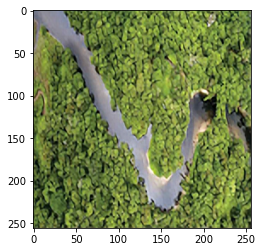

In [116]:
plt.imshow(pred/255)
plt.show()

In [140]:
img_r = cv2.imread('Processed.png')

In [142]:
pred = history.model.predict(img_r.reshape(1,256,256,3)).reshape(512,512,3)

1/1 [==============================] - 0s 497ms/step


In [143]:
cv2.imwrite('pred.png',pred)

True

In [ ]:
#Saving Model
history.model